## Importing Libraries 

In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import distance
import time
import warnings
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, precision_recall_curve, precision_score, recall_score
from catboost import CatBoostClassifier, Pool

import spacy
from gensim.models.keyedvectors import KeyedVectors

warnings.filterwarnings("ignore")

## Importing data 

In [ ]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
test_labels = pd.read_csv('../input/test_labels.csv')

In [ ]:
train_df.sample(2)

In [ ]:
test_df.sample(2)

In [ ]:
test_labels.sample(2)

## Cleaning and extracting features 

In [ ]:
# get ip addresses
def ip_add(string):
    text=re.findall('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',string)
    return text

In [ ]:
# get mac addresses
def mac_add(string):
    text=re.findall('(?:[0-9a-fA-F]:?){12}',string)
    return text

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(text):
    
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    text = str(text).lower()
    text = text.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is").replace("it's", "it is")
    text = text.replace(",000", "k").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")
    text = text.replace("′", "'").replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    text = text.replace("’", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    text = text.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")
    text = text.replace("€", " euro ").replace("'ll", " will")                       
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    
    
    porter = SnowballStemmer(language='english')
    pattern = re.compile('\W')
    
    if type(text) == type(''):
        text = re.sub(pattern, ' ', text)
    
    
    if type(text) == type(''):
        text = porter.stem(text)
        example1 = BeautifulSoup(text)
        text = example1.get_text()
                   
    return text

In [ ]:
train_df['num_mac'] = [len(i) for i in train_df['comment_text'].apply(lambda x: mac_add(x))]
train_df['num_ip'] = [len(i) for i in train_df['comment_text'].apply(lambda x: ip_add(x))]
test_df['num_mac'] = [len(i) for i in test_df['comment_text'].apply(lambda x: mac_add(x))]
test_df['num_ip'] = [len(i) for i in test_df['comment_text'].apply(lambda x: ip_add(x))]

In [ ]:
train_df['processed_comments'] = train_df['comment_text'].apply(lambda x : preprocess(x))
test_df['processed_comments'] = test_df['comment_text'].apply(lambda x : preprocess(x))

In [ ]:
train_df.head(2)

In [ ]:
def final(sent):
             
    sent = str(sent)
    final_sent = []
    for word in sent.split(' '):
        if len(word) > 2:
            final_sent.append(word)
        
    sent = ' '.join(final_sent)
    
    return sent

In [ ]:
train_df['final_processed_comments'] = train_df['processed_comments'].apply(lambda x : final(x))
test_df['final_processed_comments'] = test_df['processed_comments'].apply(lambda x : final(x))

In [ ]:
train_df.head(2)

In [ ]:
final_train = train_df
final_test = test_df

#### Getting word and comment lengths 

In [ ]:
final_train['comment_length'] = [len(i) for i in final_train['final_processed_comments']]
final_test['comment_length'] = [len(i) for i in final_test['final_processed_comments']]
final_train['num_words'] = final_train['final_processed_comments'].apply(lambda x: len(list(str(x).strip().split(' '))))
final_test['num_words'] = final_test['final_processed_comments'].apply(lambda x: len(list(str(x).strip().split(' '))))

In [ ]:
final_train.head(2)

In [ ]:
final_train.to_csv('final_train.csv',index = False)

In [ ]:
final_test.to_csv('final_test.csv', index=False)

#### Free some memory 

In [ ]:
try:
    del(final_train)
    del(final_test)
    del(train_df)
    del(test_df)

## Stage-2 Data Vectorization 

For this we will use tfidf weighted Glove model

In [ ]:
train_df = pd.read_csv('final_train.csv')
test_df = pd.read_csv('final_test.csv')

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:
train_df['final_processed_comments'].fillna(value = 'neutral', inplace=True)
test_df['final_processed_comments'].fillna(value='neutral', inplace=True)

In [ ]:
comments_train = train_df['final_processed_comments']
comments_test = test_df['final_processed_comments']

In [ ]:
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(comments_train)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

In [ ]:
vec_train = []
vec_test = []

## Train Data Vectorization

In [ ]:
# tqdm is used to print the progress bar

for text in tqdm(list(train_df['final_processed_comments']), total=len(list(train_df['final_processed_comments']))):
    doc_train = nlp(text) 
    # 384 is the number of dimensions of vectors 
    mean_vec_train = np.zeros([len(doc_train), len(doc_train[0].vector)])
    for word in doc_train:
        # word2vec
        vec_train = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        # compute final vec
        mean_vec_trian += vec_train * idf
    mean_vec_trian = mean_vec_trian.mean(axis=0)
    vecs1.append(mean_vec1)

In [ ]:
train_df['final_features'] = list(vecs1)

In [ ]:
train_df = train_df.drop(columns = ['comment_text', 'processed_comments', 'final_processed_comments'])

## Test Data Vectorization

In [ ]:
for text in tqdm(list(test_df['final_processed_comments'])):
    doc2 = nlp(text) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

In [ ]:
test_df['final_features'] = list(vecs2)

In [ ]:
test_df = test_df.drop(columns = ['comment_text', 'processed_comments', 'final_processed_comments'])

## merging Data 

In [ ]:
new_train_df = pd.DataFrame(train_df.final_features.tolist(), index=train_df.id)
new_test_df = pd.DataFrame(test_df.final_features.tolist(), index=test_df.id)

In [ ]:
final_train_df = final_train_df.merge(new_df, on='id', how='left')
final_test_df = final_df_test.merge(new_test_df, on='id', how='left')

## Exporting vactorized Data

In [ ]:
final_train_df.to_csv('final_train.csv')
final_test_df.to_csv('final_test.csv')

In [ ]:
try:
    del(final_train_df)
    del(final_test_df)
    del(train_df)
    del(test_df)

# Stage-4 Modeling 

### Importing data

In [4]:
train_df = pd.read_csv('final_train_df.csv')
test_df = pd.read_csv('final_test_df.csv')

In [5]:
train_df.head(2)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_mac,num_ip,comment_length,...,290,291,292,293,294,295,296,297,298,299
0,0000997932d777bf,0,0,0,0,0,0,0,1,236,...,-26.617639,3.115361,27.186746,1.347031,23.277589,-27.263650,-30.924321,-6.344175,-8.385335,10.314029
1,000103f0d9cfb60f,0,0,0,0,0,0,0,0,84,...,-5.467702,7.260738,-4.124895,-3.509965,7.998467,4.581659,-11.255056,1.793695,-0.856414,12.265873


In [6]:
test_df.head(2)

,id,num_mac,num_ip,comment_length,num_words,0,1,2,3,4,...,290,291,292,293,294,295,296,297,298,299
0,00001cee341fdb12,0,0,308,57,-70.646297,-9.564419,-33.322276,-42.444433,41.486150,...,-13.047228,-27.670650,-56.505865,-61.922946,42.179659,39.043858,-19.611721,7.131358,13.949408,35.554143
1,0000247867823ef7,0,0,27,6,-6.001915,-1.265123,-5.982342,-1.040156,1.231593,...,-0.141566,-4.428361,-2.142186,2.069510,2.011599,6.609734,-1.418455,-7.000040,-9.390437,3.465934


### To draw confusion  matrix

In [8]:
# we convert all the features into numaric before we apply any model
cols = list(train_df.columns)[1:]
for i in tqdm(cols):
    train_df[i] = train_df[i].apply(pd.to_numeric)
    
# we convert all the features into numaric before we apply any model
cols = list(test_df.columns)[1:]
for i in tqdm(cols):
    test_df[i] = test_df[i].apply(pd.to_numeric)

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Splitting the data 

In [17]:
train_features = train_df.drop(columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'id'])
train_labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_df_features = test_df.drop(columns='id')

In [18]:
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3)

In [19]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((111699, 304), (47872, 304), (111699, 6), (47872, 6))

## Classifier Chains - A xgboost Classifier

In [20]:
submission_chains = pd.read_csv('../input/sample_submission.csv')

In [21]:
xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0)

In [22]:
# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

... Processing toxic
Training Accuracy is 0.9902505841592136
Test Accuracy is 0.9513494318181818
Shape of x_train is now (111699, 305)
Shape of x_test is now (47872, 305)
Train Confusion Matrix:


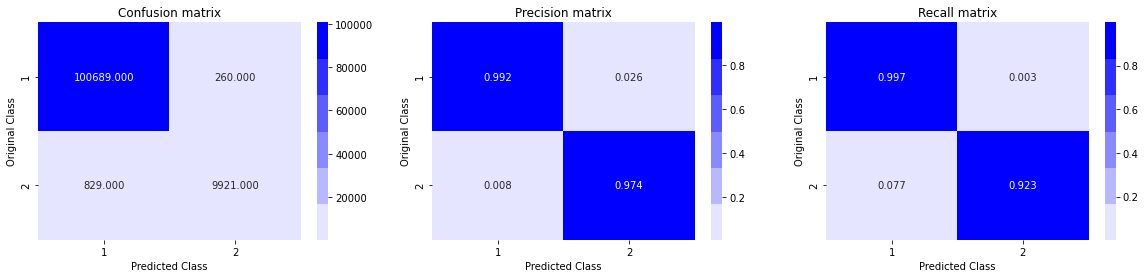


 Test Confusion Matrix:


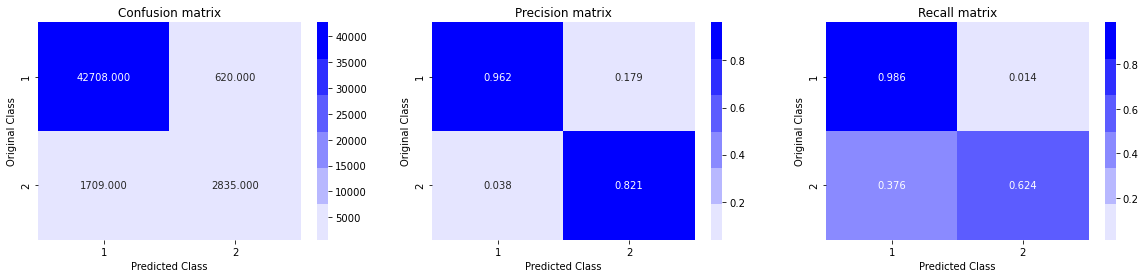

Shape of test_df is now (153164, 305)
... Processing severe_toxic
Training Accuracy is 0.9999104736837393
Test Accuracy is 0.9901612633689839
Shape of x_train is now (111699, 306)
Shape of x_test is now (47872, 306)
Train Confusion Matrix:


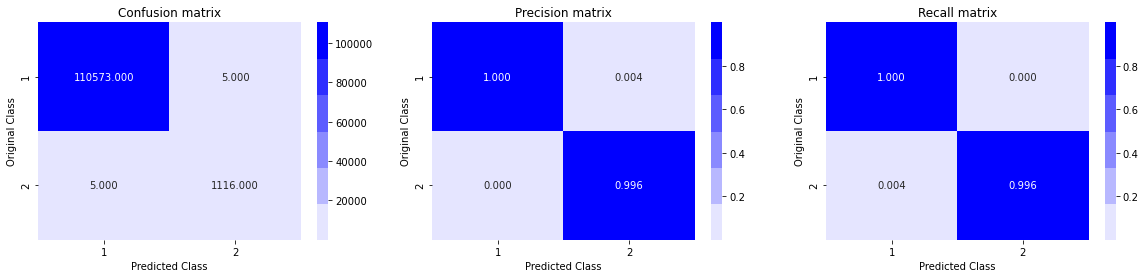


 Test Confusion Matrix:


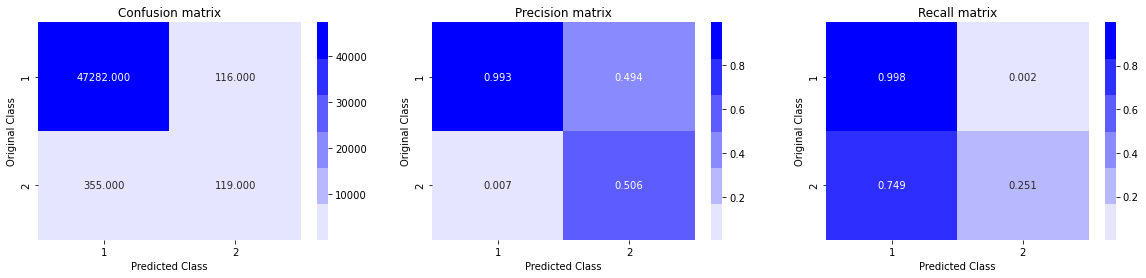

Shape of test_df is now (153164, 305)
... Processing obscene
Training Accuracy is 0.9996150368400791
Test Accuracy is 0.9758731617647058
Shape of x_train is now (111699, 307)
Shape of x_test is now (47872, 307)
Train Confusion Matrix:


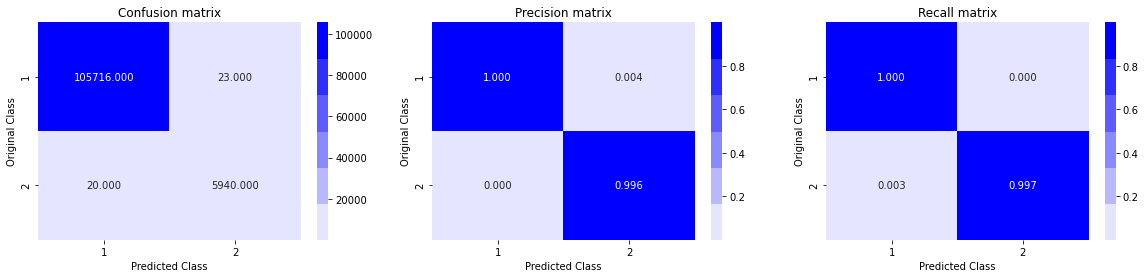


 Test Confusion Matrix:


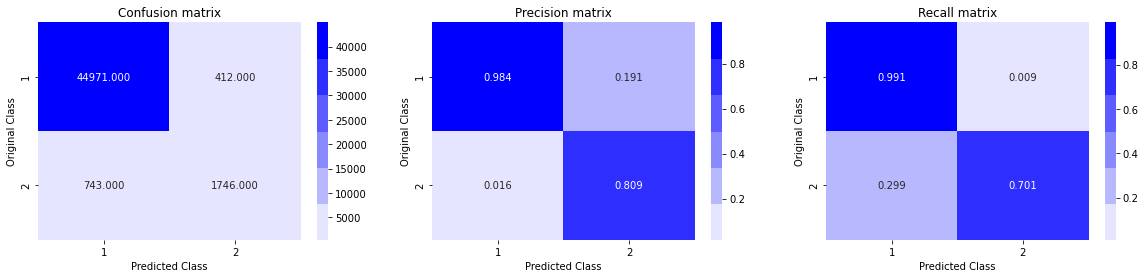

Shape of test_df is now (153164, 305)
... Processing threat
Training Accuracy is 0.9999641894734957
Test Accuracy is 0.9970755347593583
Shape of x_train is now (111699, 308)
Shape of x_test is now (47872, 308)
Train Confusion Matrix:


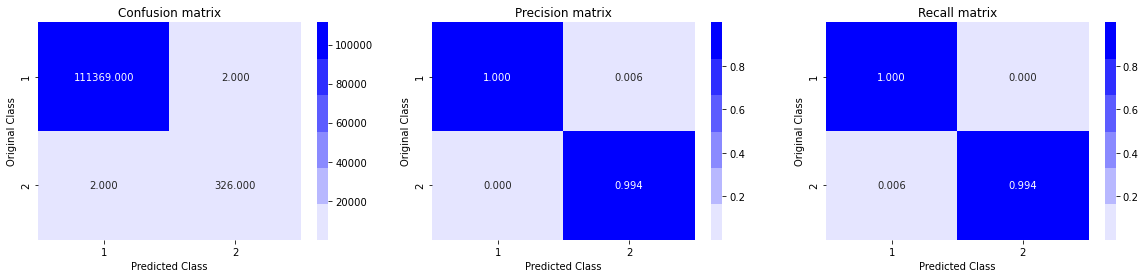


 Test Confusion Matrix:


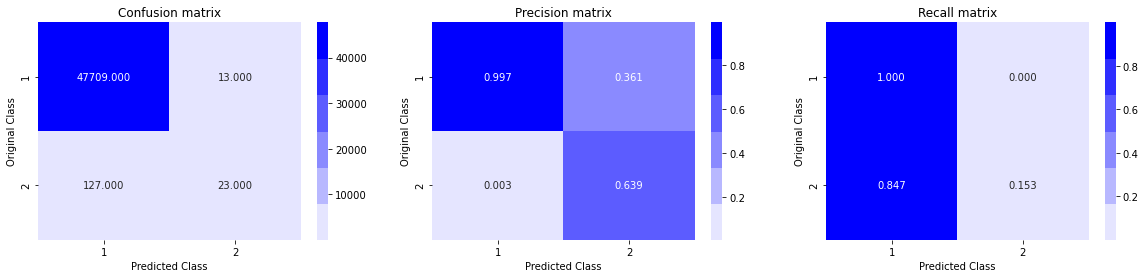

Shape of test_df is now (153164, 305)
... Processing insult
Training Accuracy is 0.9997403736828441
Test Accuracy is 0.9765625
Shape of x_train is now (111699, 309)
Shape of x_test is now (47872, 309)
Train Confusion Matrix:


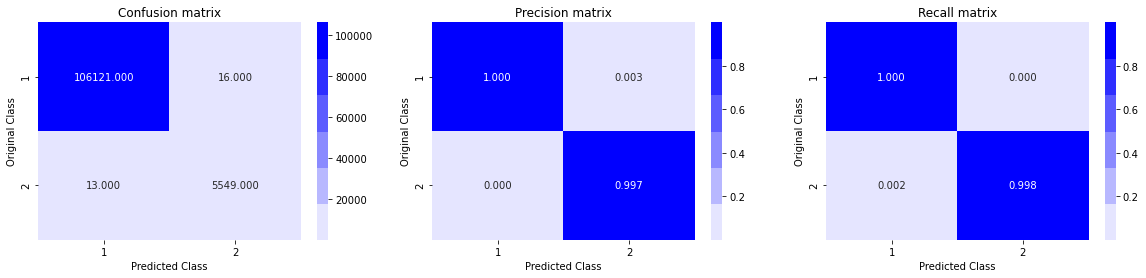


 Test Confusion Matrix:


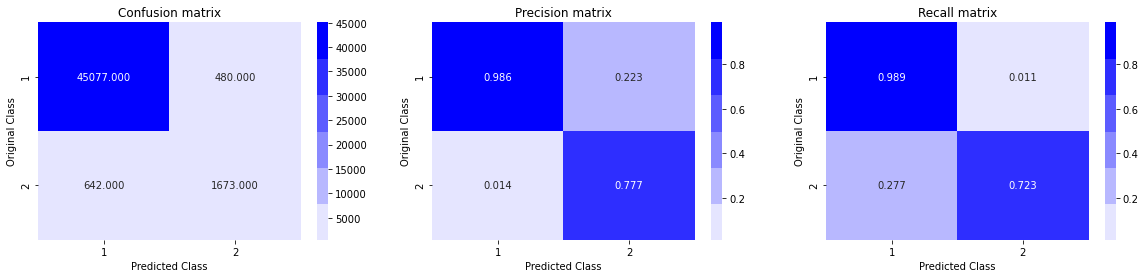

Shape of test_df is now (153164, 305)
... Processing identity_hate
Training Accuracy is 0.9999731421051218
Test Accuracy is 0.9929186163101604
Shape of x_train is now (111699, 310)
Shape of x_test is now (47872, 310)
Train Confusion Matrix:


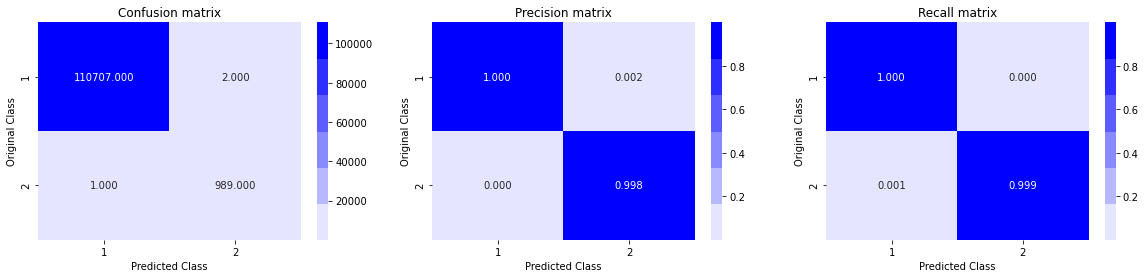


 Test Confusion Matrix:


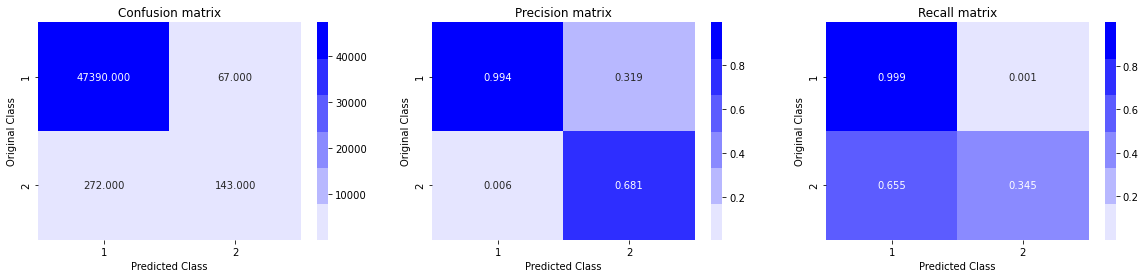

Shape of test_df is now (153164, 305)


In [23]:
for label in train_labels.columns:
    
   
    print('... Processing {}'.format(label))
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    # train the model using x_train & y_train_label
    xgb.fit(x_train,y_train_label)
    
    # compute the training accuracy
    y_pred_X = xgb.predict(x_train)
    print('Training Accuracy is {}'.format(accuracy_score(y_train_label,y_pred_X)))
    
    # make predictions from x_test and compute test accuracy
    y_test_pred = xgb.predict(x_test)
    print('Test Accuracy is {}'.format(accuracy_score(y_test_label, y_test_pred)))
    y_test_prob = xgb.predict_proba(x_test)[:,1]
        
    # chain current label to x_train
    x_train = add_feature(x_train, y_train[label])
    print('Shape of x_train is now {}'.format(x_train.shape))
    
    # chain current label predictions to x_test
    x_test = add_feature(x_test, y_test_label)
    print('Shape of x_test is now {}'.format(x_test.shape))
    
    print('Train Confusion Matrix:')
    plot_confusion_matrix(y_train_label, y_pred_X)
    print('\n Test Confusion Matrix:')
    plot_confusion_matrix(y_test_label, y_test_pred)
    
    
    
    
    # Making submission file
    test_df_pred = xgb.predict(test_df_features)
    test_df_prob = xgb.predict_proba(test_df_features)[:,1]
    submission_chains[label] = test_df_prob
    test_df_features = add_feature(test_df_features, test_df_prob)
    print('Shape of test_df is now {}'.format(test_df.shape))

In [24]:
submission_chains.shape

(153164, 7)

In [25]:
submission_chains.head(2)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.987757,0.084406,0.999099,0.009887,0.999306,0.969559
1,0000247867823ef7,0.002824,0.000050,0.502230,0.000018,0.131981,0.006548


In [26]:
submission_chains.to_csv('submission_xgboost.csv', index=False)